# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/home/oli/Research/Joe/agent-goals/code'

In [4]:
from matplotlib import pyplot as plt

import numpy as np
np.set_printoptions(precision=3)
import torch

from pdg.dist import RawJointDist, CPT
from pdg.dist import RawJointDist as RJD
from pdg.rv import Variable, binvar, Unit
from pdg.lib import A,B,C,D
from pdg.pdg import PDG

from pdg.utils import nparray_of as narr
from pdg.lib import square

In [4]:
M = square.with_rand_cpts
M.hypergraph_object

(['A', 'B', 'C', 'D'],
 {'p1': [['B', 'C'], ['A']],
  'p2': [['A', 'D'], ['B']],
  'p3': [['A', 'D'], ['C']],
  'p4': [['B', 'C'], ['D']]})

(['A', 'B', 'C'],
 {'p1': [['A', 'C'], ['B']], 'p2': [['B'], ['A']], 'p3': [['B'], ['C']]})

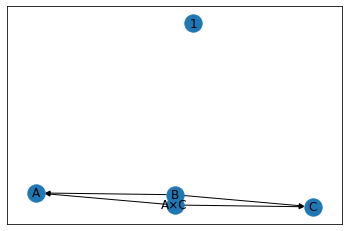

In [7]:
Q = PDG()
Q += A, B, C
Q += B|(A&C), A|B, C|B

mu = Q.genΔ()
M = Q.make_edge_mask(mu)

M.draw()
M.hypergraph_object

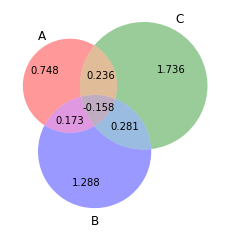

In [8]:
mu.info_diagram(A,C,B)

In [9]:
mu2 = M.iter_GS_beta()

In [10]:
muopt = M.optimize_score(0.00001)

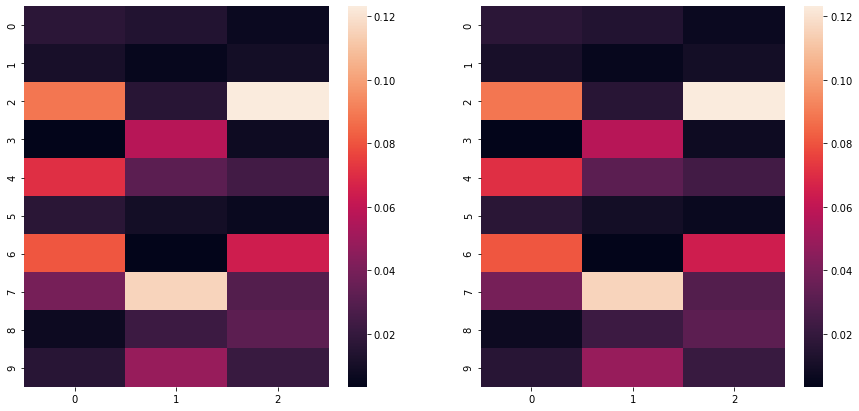

In [11]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
sns.heatmap(muopt[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax1)
sns.heatmap(mu[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax2)

In [12]:
# The two are very close, but not identical:
print("square error",  ((mu.data-muopt.data)**2).sum() )
print("relative entropies",  mu // muopt,  muopt // mu )

square error 1.0325502392738214e-09
relative entropies 1.316030114461735e-08 1.3160746189422666e-08


In [13]:
L = M.standard_library()

In [14]:
L.decoder = lambda vec : RJD(vec, M.varlist)

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit( np.vstack([ t for S,t in L.raw ]) )

PCA(n_components=2)

In [16]:
L.tags

{'GS', 'gibbs', 'i', 'opt', 'ordered', 'product', 'β', 'γ', 'φ', '≺'}

In [17]:
X,Y = pca.transform(np.vstack([dist.data.reshape(-1) for dist in L('opt').without('i').along('γ')])).T

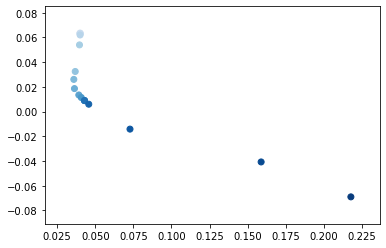

In [18]:
from matplotlib.cm import get_cmap
cmap = get_cmap("Blues")
plt.scatter(X,Y, c=cmap(np.linspace(0.0,0.95,len(X))))
plt.show()

In [19]:
from pdg.distviz import pca_view

Explained_variance: [1.000e+00 2.601e-15] 	(total: 1.000000)


array([[[ 4.710e-11,  1.591e-11, -4.535e-11,  5.696e-12, -8.253e-11],
        [ 3.492e-11,  7.287e-12, -3.097e-12,  8.433e-11, -4.896e-11],
        [ 2.044e-11,  1.129e-11, -4.540e-11,  2.029e-11, -3.912e-11]],

       [[-5.815e-11, -4.346e-11,  2.289e-11, -9.507e-12,  2.253e-11],
        [-2.728e-11, -2.223e-12,  7.838e-11, -1.658e-11,  7.223e-11],
        [-2.605e-11, -2.322e-11,  1.703e-11, -2.233e-11,  3.292e-11]]])

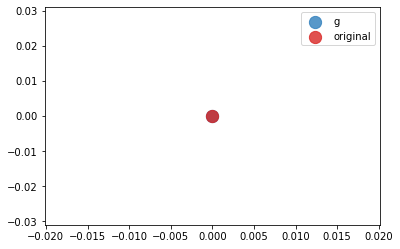

In [20]:
pca_view( g = [+ L('opt',γ=0).without('i')] ,  original=[mu.data])
(+ L('opt',γ=0).without('i')).data - mu.data

In [24]:
L.tag_sort(M.IDef)
None

In [85]:
t = torch.tensor([[[0.0000, 0.0114, 0.1129, 0.0000, 0.0959],
         [0.0000, 0.0061, 0.0212, 0.0121, 0.0458],
         [0.0000, 0.0099, 0.1514, 0.0000, 0.0377]],
        [[0.0376, 0.0936, 0.0284, 0.0125, 0.0054],
         [0.0192, 0.0000, 0.0760, 0.0396, 0.0153],
         [0.0150, 0.0747, 0.0205, 0.0495, 0.0084]]])

rjt = RJD(t, M.varlist, use_torch=True)


np.isfinite(rjt.prob_matrix(B|A,C))

tensor([[[0, 1, 1, 1, 1],
         [0, 1, 1, 1, 1],
         [0, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)

In [278]:
mu_torch_converted = RJD(mu.data, mu.varlist, use_torch=True)
muopt_torch_converted = RJD(muopt.data, mu.varlist, use_torch=True)
M.torch_score(mu_torch_converted, 0), M.torch_score(muopt_torch_converted, 0)

# mu_torch_converted.prob_matrix(B|A,C)
# mu_torch_converted.data.sum(dim=[])
# mu[B|A&C] - M[B|A&C]
# mu.H(...)

(tensor(9.1352e-17), tensor(2.4069e-10))

# Optimization Playground

In [403]:
# torch.autograd.set_detect_anomaly(False)
mu_opt_torch, iterates, losses = M._torch_opt_inc(0, iters=3000, ret_iterates=True, extraTemp=1E-12)
# plt.plot([np.log(l)/np.log(10) for l in losses])
min(losses)

[2999/3000]  loss:  3.692e-09;  lr: 7.804e-04

1.2009642169630297e-09

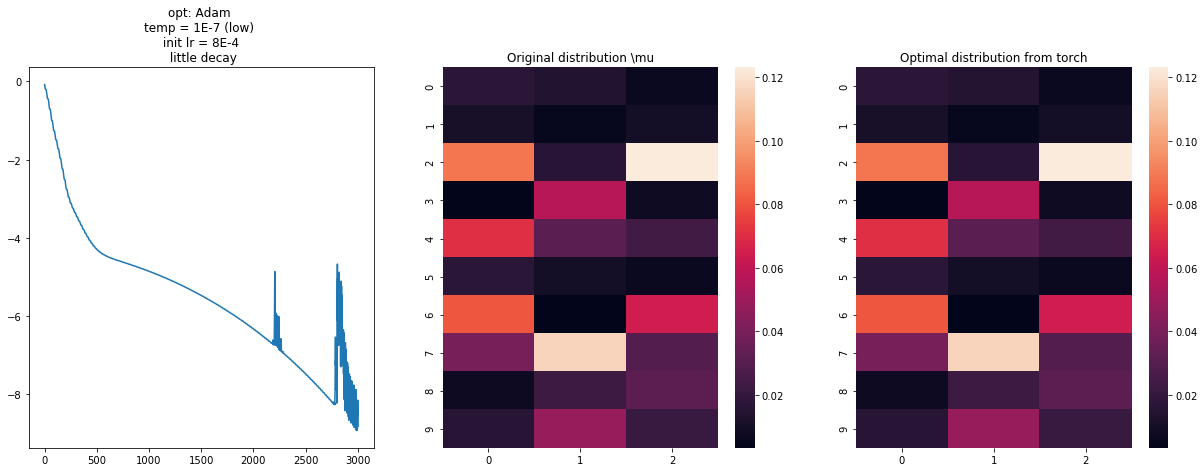

In [404]:
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(21,7))

ax0.plot([np.log(l)/np.log(10) for l in losses])
ax0.set_title("opt: Adam \ntemp = 1E-7 (low) \n init lr = 8E-4 \n little decay")

ax1.set_title("Original distribution \\mu")
ax2.set_title("Optimal distribution from torch")
sns.heatmap(muopt[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax1)
# sns.heatmap(mu[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax2)
# sns.heatmap(mu_opt_torch.prob_matrix(A&C, B).numpy().reshape(len(A)*len(C), len(B)), ax=ax3)
# mu_opt_torch[A&C, B]
# sns.heatmap(mu_opt_torch.prob_matrix(A&C, B).numpy().reshape(len(A)*len(C), len(B)), ax=ax2)
sns.heatmap(mu_opt_torch[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax2)



In [ ]:
pt_inc(0,iters=2000)
plt.plot([np.log(l)/np.log(10) for l in losses])
plt.set_title("")

In [409]:
print([M.IDef(mu_opt_torch).item(), M.IDef(mu), M.IDef(muopt)] + [ M.IDef(t) for S,t in L('GS').without('i') ])
print([M.Inc(RJD(mu_opt_torch.data,M.varlist)), M.Inc(mu), M.Inc(muopt)] + [ M.Inc(t) for S,t in L('GS').without('i') ])

[-0.059641652131315226, -0.059556480101481846, -0.05960463550032791, -0.12523175580384516, -0.13964105646261715]
[(1.2009640375745805e-09+0j), 0j, (2.406873254478574e-10+0j), (0.08435430915066713+0j), (0.1753766918129482+0j)]


[frozenset({'GS', 'gibbs', 'β'}), frozenset({'GS', 'gibbs', 'ordered', '≺'})]

In [387]:
test = RJD(M.genΔ().data, M.varlist, use_torch=True)
P = test.prob_matrix(B|A)
D = test.data
torch.log( torch.where(P==0,1.,P))*D

tensor([[[-3.0851e-03, -1.1532e-01, -7.5738e-05, -1.8884e-02, -4.9539e-02],
         [-1.2545e-02, -9.5771e-02, -1.4315e-02, -5.1200e-02, -1.3652e-02],
         [-3.3534e-03, -1.4881e-02, -1.7401e-02, -5.2899e-02, -8.5554e-02]],

        [[-6.3611e-02, -3.5263e-04, -1.2880e-02, -5.9097e-02, -4.0468e-02],
         [-4.8562e-03, -3.8875e-02, -5.3133e-02, -4.1901e-02, -3.6283e-02],
         [-2.1258e-02, -2.9461e-02, -5.4256e-02, -5.0804e-02, -1.3326e-02]]],
       dtype=torch.float64)

# Now the converse: do the same for a distribution that has the independences of the DN.  

In [410]:
MII = square.consist_with_P

In [688]:
cmu_gs_b = MII.iter_GS_beta()
cmu_gs_o = MII.iter_GS_ordered()
print('GS finished')
cmu_opt, losses = MII._torch_opt_inc(gamma=1E-6,iters=4000, ret_losses=True, extraTemp=0)
min(losses)


GS finished
[3995/4000]  loss:  -4.126e-07;  lr: 9.608e-02

-4.125861039483425e-07

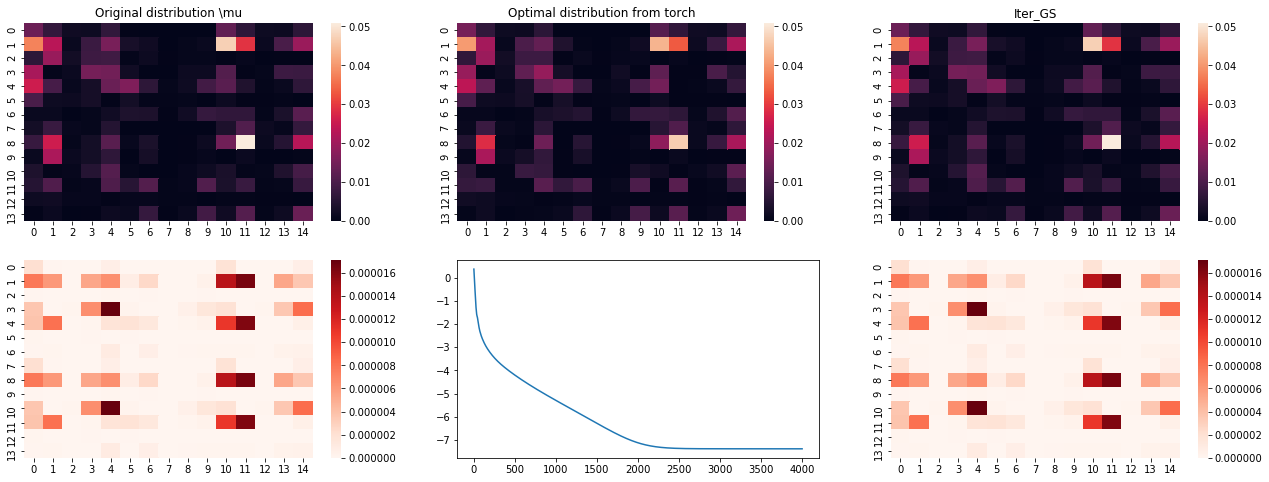

In [560]:
fig, ((ax1, ax2, ax3), (ax4,ax0,ax5)) = plt.subplots(2,3,figsize=(22,8))

nrows = len(MII('A D'))
ncols = len(MII('B C'))
A,B,C,D = MII.varlist

ax0.plot([np.log(l - min(losses) - min(losses)/10)/np.log(10) for l in losses])
ax1.set_title("Original distribution \\mu")

vparams = dict(vmax=np.stack([m.data for m in [cmu_gs_o,cmu_gs_b, cmu_opt, square.P]]).max(), vmin=0)

sns.heatmap(square.P[A&D, B&C].to_numpy().reshape(nrows, ncols), ax=ax1, **vparams)
# sns.heatmap(mu[A&C, B].to_numpy().reshape(len(A)*len(C), len(B)), ax=ax2)
# sns.heatmap(mu_opt_torch.prob_matrix(A&C, B).numpy().reshape(len(A)*len(C), len(B)), ax=ax3)
# mu_opt_torch[A&C, B]
# sns.heatmap(mu_opt_torch.prob_matrix(A&C, B).numpy().reshape(len(A)*len(C), len(B)), ax=ax2)
ax2.set_title("Optimal distribution from torch")
sns.heatmap(cmu_opt[A&D, B&C].to_numpy().reshape(nrows, ncols), ax=ax2, **vparams)
ax3.set_title("Iter_GS")
sns.heatmap(cmu_gs_b[A&D, B&C].to_numpy().reshape(nrows, ncols), ax=ax3, **vparams)
sns.heatmap(((square.P[A&D, B&C].to_numpy() - cmu_opt[A&D, B&C].to_numpy())**2).reshape(nrows,ncols), cmap='Reds', vmin=0, ax=ax4)
sns.heatmap(((cmu_gs_b[A&D, B&C].to_numpy() - cmu_opt[A&D, B&C].to_numpy())**2).reshape(nrows,ncols), cmap='Reds', vmin=0, ax=ax5)

It seems that both IDef and Inc are better for the gibbs-sampled versions, which means that I'm again gated by the optimizer. 

In [561]:
dists = {'P': square.P, 'GS.b': cmu_gs_b, "GS.o": cmu_gs_o, "opt": RJD(cmu_opt.data,MII.varlist)}

print("Incs: ", [MII.Inc(mu).real for mu in  dists.values()])
print("IDefs: ", [MII.IDef(mu) for mu in dists.values() ])

print()
print("dist (GS_beta, P) = ", cmu_gs_b // square.P)
print("dist (opt, P) = ", cmu_opt // square.P, '  ', square.P // cmu_opt)
print("dist (opt, GS_beta) = ", cmu_opt // cmu_gs_b, '  ', cmu_gs_b // cmu_opt)

print()
print("Inc Vectors")
import pandas as pd
f = pd.DataFrame({k:MII.Inc(mu, ed_vector=True).real for k,mu in dists.items()})
f.rename(index=dict(enumerate(MII.edges('Xn,Yn'))))

Incs:  [0.0, 2.0949557013229292e-16, -4.596242591500494e-17, 2.941922321920241e-13]
IDefs:  [-0.4526172765857803, -0.4526172765857811, -0.45261727658577944, -0.41258617512639506]

dist (GS_beta, P) =  2.5337657146728287e-16
dist (opt, P) =  0.02774774695332298    0.03861768092935307
dist (opt, GS_beta) =  0.027747746953322727    0.038617680929353304

Inc Vectors


P          GS.b          GS.o           opt
(B×C, B)  0.0  0.000000e+00  0.000000e+00  0.000000e+00
(B×C, C)  0.0  0.000000e+00  0.000000e+00  0.000000e+00
(B×C, A)  0.0  1.757573e-19 -1.986106e-17  3.626094e-14
(A×D, A)  0.0  0.000000e+00  0.000000e+00  0.000000e+00
(A×D, D)  0.0  0.000000e+00  0.000000e+00  0.000000e+00
(A×D, B)  0.0  2.966709e-17  1.593708e-17  7.477550e-14
(A×D, C)  0.0  9.013187e-17 -2.400992e-17  6.842216e-14
(B×C, D)  0.0  8.952084e-17 -1.802852e-17  1.147336e-13

### But... what about the gradient at the minimum?

In [684]:
# l = MII.torch_score(, 0)
# l.backward()
print('\tFor: \t\t {:^8} \t {:^10}'.format(
    "GS (beta avg)",
    "optimal"
), '\n','_'*50)

cmu_gs_b.require_grad()
cmu_opt.require_grad()

print('values of score\t\t {:< 8.4g} \t {:< 8.4g}'.format(
    MII.torch_score(cmu_gs_b, 0).item(),
    MII.torch_score(cmu_opt, 0).item()
))

cmu_gs_b.data.grad = None
cmu_opt.data.grad = None

MII.torch_score(cmu_gs_b, 0).backward()
MII.torch_score(cmu_opt, 0).backward()
print('l2 norm of ∇score\t {:< 8.4g} \t {:< 8.4g}'.format(
    torch.norm(cmu_gs_b.data.grad, 1).item(),
    torch.norm(cmu_opt.data.grad, 1).item()
))

cmu_gs_b.data.grad = None
cmu_opt.data.grad = None

lgs, lopt = MII.IDef(cmu_gs_b), MII.IDef(cmu_opt)
print('values of IDef\t\t {:< 8.4g} \t {:< 8.4g}'.format( \
    lgs.item(), lopt.item())
)

lgs.backward(); lopt.backward()

print('l2 norm of ∇IDef\t {:< 8.4g} \t {:< 8.4g}'.format(
    torch.norm(cmu_gs_b.data.grad, 2).item(),
    torch.norm(cmu_opt.data.grad, 2).item()
))

	For: 		 GS (beta avg) 	  optimal   
 __________________________________________________
values of score		  7.433e-17 	  2.943e-13
l2 norm of ∇score	  1.113e-11 	  0.0003236
values of IDef		 -0.4526  	 -0.4126 
l2 norm of ∇IDef	  41.1    	  41.25  


It seems the gradient of the score is very small. The gradient of IDef is not, though; this is a constrained optimization task, and the gradient will point away from the constraint. Can we solve it with the method of Lagrange Multipliers? No. That would require $\nabla g(x,y) \ne 0$ (the so-caled constraint qualification), and our constraint is that $Inc = 0$. And because that point is a global minimum of Inc, a convex smooth function, the gradient is zero at any such point.

We can see that directly from the fact that gradient is very small, as we can see from $\nabla_\mu$`torch_score(mu,0)` = $\nabla_\mu$`Inc(mu)`, in he cell below:

In [685]:
cmu_gs_b.require_grad()
MII.torch_score(cmu_gs_b,0).backward()
print('l1 norm: {:.4g}, \t l2 norm: {:.4g}, \t l_infty norm: {:.5g}'.format(    
    torch.norm(cmu_gs_b.data.grad,1),torch.norm(cmu_gs_b.data.grad,2), torch.norm(cmu_gs_b.data.grad,float('inf')) ))

l1 norm: 1.113e-11, 	 l2 norm: 9.497e-13, 	 l_infty norm: 1.6562e-13


# Finding multiple points consistent with it
It would be nice to find a lot of points in Inc(M), some which maximize and minimize IDef, and plot them together with the fixed point from Gibbs Sampling. 
The approach:
 - random initialization
 - small values of $\gamma = \pm \epsilon$ with both signs.

In [793]:
from pdg.store import TensorLibrary, prettify_selector
dists = TensorLibrary(decoder=lambda d: RJD(d, MII.varlist))

def liftmult(fun, factor):
    return lambda *a, **k: fun(*a, **k) * scale

niters = 2000
for j in range(2):
    # random initialization
    for scale in [1]:
        # for repres in ['gibbs', 'softclip+normalize', 'clip+normalize']:
        for repres in ['gibbs']:
            for gamma,extratemp in [(1E-10,1E-5), (-1E-10, -1E-5)]:
                print('\n***=>>\t', gamma, scale, repres, j)
                rjd_opt, iters, losses = MII._torch_opt_inc(gamma=gamma,iters=niters, 
                    ret_losses=True, ret_iterates=True, extraTemp=extratemp, 
                    representation=repres,
                    init=liftmult(torch.rand, scale))
                dists("rand", "opt", gamma=gamma,scale=scale,j=j, rep=repres, 
                    loss='{:.4e}'.format(min(losses))).set(rjd_opt.data)
                for i, (mu,l) in enumerate(zip(iters,losses)):
                    if i%(niters//57) == 0:
                        dists("rand", i=i, gamma=gamma, scale=scale,j=j, rep=repres, loss='{:.4e}'.format(l) ).set(mu.data)




***=>>	 1e-10 1 gibbs 0
[1989/2000]  loss:  1.569e-07;  lr: 9.803e-02
***=>>	 -1e-10 1 gibbs 0
[1989/2000]  loss:  7.318e-08;  lr: 9.803e-02
***=>>	 1e-10 1 gibbs 1
[1989/2000]  loss:  4.079e-09;  lr: 9.803e-02
***=>>	 -1e-10 1 gibbs 1
[1989/2000]  loss:  3.684e-08;  lr: 9.803e-02

In [726]:
# print(np.sum(np.isnan(np.stack([d.data for d in dists.tensors]))) / MII.genΔ().data.size)
{prettify_selector(S) : np.sum(np.isnan(t)) for S,t in dists.raw}

2.0


{'opt; rand; scale=1; loss=1.8647e-01; gamma=1e-10; j=0': 0,
 'rand; it=20; scale=1; gamma=1e-10; loss=inf; j=0': 0,
 'rand; it=20; scale=1; loss=2.4211e+00; gamma=1e-10; j=0': 0,
 'rand; it=20; scale=1; loss=2.1129e+00; gamma=1e-10; j=0': 0,
 'loss=1.8367e+00; rand; it=20; scale=1; gamma=1e-10; j=0': 0,
 'rand; it=20; scale=1; gamma=1e-10; loss=1.5922e+00; j=0': 0,
 'rand; it=20; scale=1; loss=1.3783e+00; gamma=1e-10; j=0': 0,
 'loss=1.1934e+00; rand; it=20; scale=1; gamma=1e-10; j=0': 0,
 'rand; it=20; scale=1; gamma=1e-10; loss=1.0347e+00; j=0': 0,
 'loss=8.9923e-01; rand; it=20; scale=1; gamma=1e-10; j=0': 0,
 'loss=7.8357e-01; rand; it=20; scale=1; gamma=1e-10; j=0': 0,
 'loss=6.8462e-01; rand; it=20; scale=1; gamma=1e-10; j=0': 0,
 'loss=5.9963e-01; rand; it=20; scale=1; gamma=1e-10; j=0': 0,
 'loss=5.2622e-01; rand; it=20; scale=1; gamma=1e-10; j=0': 0,
 'loss=4.6243e-01; rand; it=20; scale=1; gamma=1e-10; j=0': 0,
 'rand; it=20; scale=1; loss=4.0664e-01; gamma=1e-10; j=0': 0,
 

Explained_variance: [0.89 0.06] 	(total: 0.949946)


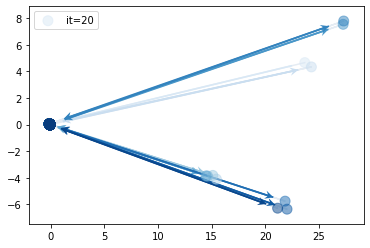

In [756]:

attrib = 'it'
constraints = []
# %matplotlib qt
# { attrib+'='+str(v) : dists('opt', **{ attrib : v}).nonnan_tensors() for v in dists.values_for_key(attrib) }
%matplotlib inline
pca_view(**{ attrib+'='+str(v) : dists(*constraints, **{ attrib : v}).nonnan_tensors() for v in dists.values_for_key(attrib) })

Explained_variance: [0.454 0.138] 	(total: 0.591742)


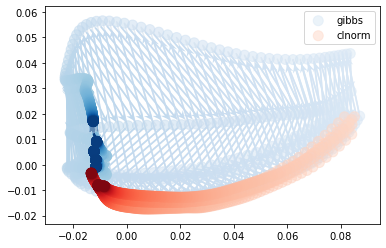

In [765]:
# [*dists(rep='gibbs',j=0).along('i')]
pca_view(
    gibbs=[t.data for t in dists(rep='gibbs').along('i')][10:],
    clnorm=[t.data for t in dists(rep='clip+normalize').along('i')][10:],
)

Explained_variance: [0.586 0.191] 	(total: 0.776838)


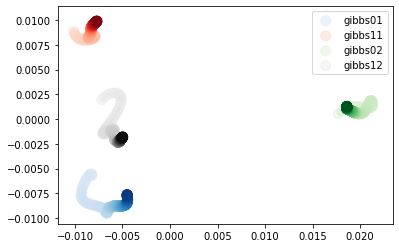

In [769]:
pca_view(
    gibbs01=[t.data for t in dists(rep='gibbs',j=0, scale=1).along('i')][40:],
    gibbs11=[t.data for t in dists(rep='gibbs',j=1, scale=1).along('i')][40:],
    gibbs02=[t.data for t in dists(rep='gibbs',j=0, scale=2).along('i')][40:],
    gibbs12=[t.data for t in dists(rep='gibbs',j=1, scale=2).along('i')][40:],
    # clnorm=[t.data for t in dists(rep='clip+normalize',j=0,scale=2).along('i')][40:],
)

Explained_variance: [0.495 0.205] 	(total: 0.699989)


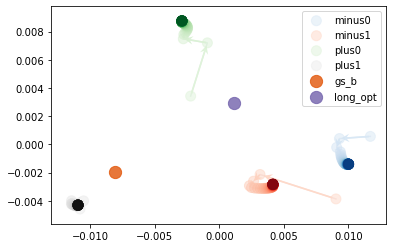

In [838]:

pca_view(
    minus0=[t.data for t in dists(j=0, gamma=-1E-10).along('i')][1:],
    minus1=[t.data for t in dists(j=1, gamma=-1E-10).along('i')][1:],
    plus0=[t.data for t in dists(j=0, gamma=1E-10).along('i')][1:],
    plus1=[t.data for t in dists(j=1, gamma=1E-10).along('i')][1:],
    gs_b = [cmu_gs_b.data], # same as square.P, and also cmu_gs_o
    long_opt = [cmu_opt],
    # unif = [np.ones(MII.dshape)/cmu_gs_b.data.size]
        # clnorm=[t.data for t in dists(rep='clip+normalize',j=0,scale=2).along('i')][40:],
)

In [808]:
long_opt.

torch.Size([2, 3, 5, 7])

[frozenset({'opt', ('rep', 'gibbs'), 'rand', ('scale', 1), ('gamma', 1e-10), ('loss', '1.5026e-07'), ('j', 0)}), frozenset({'opt', ('rep', 'gibbs'), ('gamma', -1e-10), 'rand', ('scale', 1), ('loss', '6.9551e-08'), ('j', 0)}), frozenset({'opt', ('rep', 'gibbs'), 'rand', ('scale', 1), ('loss', '3.7839e-09'), ('j', 1), ('gamma', 1e-10)}), frozenset({'opt', ('rep', 'gibbs'), ('gamma', -1e-10), 'rand', ('loss', '3.4758e-08'), ('scale', 1), ('j', 1)})]


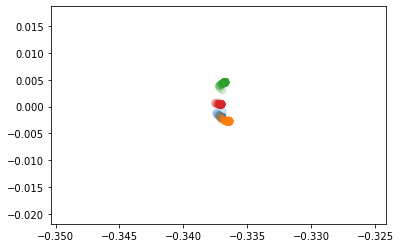

In [842]:
# %matplotlib inline
from sklearn.decomposition import PCA
from itertools import product

pca = PCA(n_components=2)
print([*dists.without('i').matches])
pca.fit(np.stack([t.data.reshape(-1) for (j,g) in product([0,1],[-1E-10,1E-10]) for t in dists(j=j, gamma=g).along('i')][1:]))
transform = pca.transform

fig,ax = plt.subplots()
for g in [-1E-10, 1E-10]:
    for j in [0,1]:
        distribs = [t for t in dists(j=j, gamma=g).along('i')][1:]
        X,Y = transform([t.data.reshape(-1) for t in distribs][1:]).T
        ax.scatter(X,Y, alpha=0.2,s=[10.0 /abs(MII.IDef(d)**2) for d in distribs])

# More Complicated Distributions, and more Samples of Them

0  |  [3, 5]
1  |  [0, 3, 2]
2  |  [4, 0, 5]
3  |  [2]
4  |  [1, 3]
5  |  [6]
6  |  [4, 3, 5]


(['X0', 'X1', 'X2', 'X3', 'X4', 'X6', 'X5'],
 {'p8': [['X3', 'X5'], ['X0']],
  'p9': [['X0', 'X3', 'X2'], ['X1']],
  'p10': [['X4', 'X0', 'X5'], ['X2']],
  'p11': [['X2'], ['X3']],
  'p12': [['X1', 'X3'], ['X4']],
  'p13': [['X6'], ['X5']],
  'p14': [['X4', 'X3', 'X5'], ['X6']]})

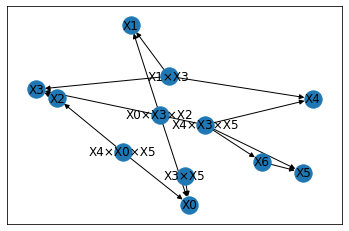

In [45]:
from pdg.rv import Variable as Var
import random

def random_semi_consist_DN(nVars = 7, n_deps=[1,2,3], nVals=[3]):
    XX = [ Var.alph('X%d'%i, random.choice(nVals)) for i in range(nVars) ]
    parents = []
    factors = []

    # for i in range(nEdges):
    #     n = random.randint(2,3)
    #     idxs = random.sample(range(N), n)
    #     tgt.append(random.choice(idxs))
    #     adj.append(idxs)
    #     factor = np.random.exponential(1, [len(XX[j]) for j in idxs]).reshape([len(XX[j]) if j in idxs else 1 for j in range(N)])
    #     factors.append(factor)
    for i in range(nVars):
        n = random.choice(n_deps)
        par = random.sample(set(range(nVars)) - {i}, n)
        parents.append(par)
        idxs = par + [i]
        print(i, ' | ', par)
        # factor = np.random.exponential(1, [len(XX[j]) for j in idxs]).reshape([len(XX[j]) if j in idxs else 1 for j in range(nVars)])
        factor = 0.01 + np.random.rand(*[len(XX[j]) for j in idxs]).reshape([len(XX[j]) if j in idxs else 1 for j in range(nVars)])
        factors.append(factor)

    total_dist = RJD(np.prod(factors),XX)
    total_dist.normalize()

    M = PDG()
    for i in range(nVars):
        srci = Var.product(*(XX[s] for s in parents[i]))
        M += total_dist[XX[i] | srci]

    # M.draw()
    return M, total_dist

M, P = random_semi_consist_DN()
# print(M.varlist)
M.draw()
M.hypergraph_object

[ 999/1000]  loss:  1.051e-02;  lr: 9.901e-02

<ipython-input-110-add300538657>:11: RuntimeWarning: invalid value encountered in log
  plt.plot([np.log(l - min(losses) - min(losses)/10)/np.log(10) for l in losses])


0.010506088845431805

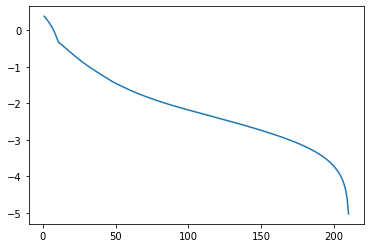

In [110]:
# _gs_b, gs_b_iter = M.iter_GS_beta(max_iters=3000, store_iters=True)
# _gs_o, gs_o_iter = M.iter_GS_ordered(max_iters=3000, store_iters=True)
# print('GS finished')
# _opt, iters, losses = M._torch_opt_inc(gamma=0,iters=3000, ret_losses=True, ret_iterates=True, extraTemp=0)
# _opt_half, iters_half, losses = M._torch_opt_inc(gamma=0.5,iters=3000, ret_losses=True, ret_iterates=True, extraTemp=0)
# _opt_one, iters_one, losses = M._torch_opt_inc(gamma=1,iters=3000, ret_losses=True, ret_iterates=True, extraTemp=0)

_opt_7, iters_7, losses = M._torch_opt_inc(gamma=1/7,iters=1000, ret_losses=True, ret_iterates=True, extraTemp=0)


plt.plot([np.log(l - min(losses) - min(losses)/10)/np.log(10) for l in losses])
min(losses)

In [104]:
print('\tFor: \t\t {:^8} \t {:^8} \t {:^10}'.format(
    "GS (beta avg)",
    "GS (ordered)",
    "optimal"
), '\n','_'*60)

_gs_b = _gs_b.torchify()
_gs_o = _gs_o.torchify()
_gs_b.require_grad()
_gs_o.require_grad()
_opt.require_grad()

print('values of score\t\t {:< 8.4g} \t {:< 8.4g} \t {:< 8.4g}'.format(
    M.torch_score(_gs_b, 0).item(),
    M.torch_score(_gs_o, 0).item(),
    M.torch_score(_opt, 0).item()
))

_gs_b.data.grad = None
_gs_o.data.grad = None
_opt.data.grad = None

M.torch_score(_gs_b, 0).backward()
M.torch_score(_gs_o, 0).backward()
M.torch_score(_opt, 0).backward()
print('l2 norm of ∇score\t {:< 8.4g} \t {:< 8.4g} \t {:< 8.4g}'.format(
    torch.norm(_gs_b.data.grad, 1).item(),
    torch.norm(_gs_o.data.grad, 1).item(),
    torch.norm(_opt.data.grad, 1).item()
))

_gs_b.data.grad = None
_opt.data.grad = None

lgs, logs, lopt = M.IDef(_gs_b), M.IDef(_gs_o), M.IDef(_opt)
print('values of IDef\t\t {:< 8.4g} \t {:< 8.4g} \t {:< 8.4g}'.format( \
    lgs.item(), logs.item(), lopt.item())
)

lgs.backward(); lopt.backward(); logs.backward()

print('l2 norm of ∇IDef\t {:< 8.4g} \t {:< 8.4g} \t {:< 8.4g}'.format(
    torch.norm(_gs_b.data.grad, 2).item(),
    torch.norm(_gs_o.data.grad, 2).item(),
    torch.norm(_opt.data.grad, 2).item()
))

print(M.torch_score(P.torchify(),0).item(), M.Inc(P).real, M.IDef(P))

	For: 		 GS (beta avg) 	 GS (ordered) 	  optimal   
 ____________________________________________________________
values of score		  0.6452  	  0.9163  	  3.469e-05
l2 norm of ∇score	  4181    	  3673    	  41.86  
values of IDef		 -0.08829 	 -0.09043 	  0.7549 
l2 norm of ∇IDef	  78.7    	  157.7   	  54.8   
-7.35759155415789e-17 0.0 -0.022477875866746738


In [111]:
# optX, optY = zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in iters))
# optX5, optY5 = zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in iters_half))
# optX1, optY1 = zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in iters_one))
optX7, optY7 = zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in iters_7))


# ordX, ordY= zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in gs_o_iter))
# bgsX, bgsY= zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in gs_b_iter))

In [106]:
P.data.min()

1.6224292666565207e-08

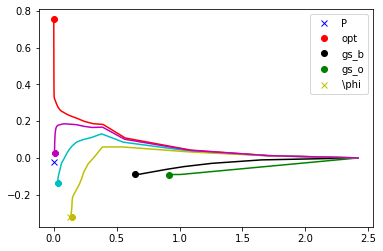

In [112]:
fig, ax = plt.subplots() 

ax.plot( M.Inc(P).real, M.IDef(P), 'bx', label="P" )
ax.plot( M.Inc(_opt.npify()).real, M.IDef(_opt.npify()), 'ro', label="opt" )
ax.plot( M.Inc(_gs_b.npify()).real, M.IDef(_gs_b.npify()), 'ko',label="gs_b" )
ax.plot( M.Inc(_gs_o.npify()).real, M.IDef(_gs_o.npify()), 'go', label="gs_o" )
fp = M.factor_product()
ax.plot( M.Inc(fp).real, M.IDef(fp), 'yx', label="\phi" )
ax.plot(optX[1::3], optY[1::3], '-r')
ax.plot(ordX[0:],ordY[0:], '-g')
ax.plot(bgsX[0::3],bgsY[0::3], '-k')
ax.plot(optX5[1:500:3],optY5[1:500:3], '-c')
ax.plot(optX1[1:500:3],optY1[1:500:3], '-y')
ax.plot(M.Inc(_opt_half.npify()).real, M.IDef(_opt_half.npify()), 'c8')
ax.plot(M.Inc(_opt_one.npify()).real, M.IDef(_opt_one.npify()), 'y8')
ax.plot(optX7[1::3],optY7[1::3], '-m')
ax.plot(M.Inc(_opt_7.npify()).real, M.IDef(_opt_7.npify()), 'm8')


ax.legend()
plt.show()

In [98]:
d = M.genΔ(RJD.random)

In [102]:

print('torch score: ', M.torch_score(d.torchify(),0), ' \t Inc: ', M.Inc(d),  ' \t other score', M.score(d))
print('torch score: ', M.torch_score(d.torchify(),1)-M.torch_score(d.torchify(),0),
     ' \t IDef: ', M.IDef(d),  ' \t other score', M.score(d, gamma=1)- M.score(d, gamma=0))


cpd = torch.tensor(d.broadcast(next(iter(M.cpds))), requires_grad=False)


torch score:  tensor(2.4649, grad_fn=<SubBackward0>)  	 Inc:  (2.464923820891358+0j)  	 other score 3.0162681682182697
torch score:  tensor(0.5513, grad_fn=<SubBackward0>)  	 IDef:  0.5513443473269117  	 other score 0.5513443473269106


# Strongly Consistent DNs
The DNs below are random 'semi'-consistent DNs; they are consistent with probability distribution, and that distribution factorizes over cliques which line up with the CPDs, but they are not the MRF dependencies. Now we construct actual consistent DNs. 

[3, 5] 	  (1, 1, 1, 3, 1, 3, 1)
[4, 2, 0] 	  (3, 1, 3, 1, 3, 1, 1)
[3, 5] 	  (1, 1, 1, 3, 1, 3, 1)
[3, 5, 0] 	  (3, 1, 1, 3, 1, 3, 1)
[5, 6, 1] 	  (1, 3, 1, 1, 1, 3, 3)

0  |  {2, 3, 4, 5}
1  |  {5, 6}
2  |  {0, 4}
3  |  {0, 5}
4  |  {0, 2}
5  |  {0, 1, 3, 6}
6  |  {1, 5}
(3, 3, 3, 3, 3, 3, 3) (3, 3, 3, 3, 3, 3, 3)


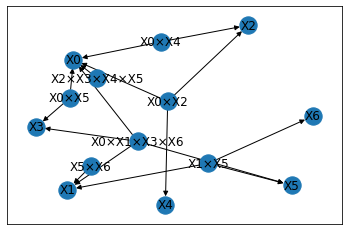

In [334]:
from pdg.rv import Variable as Var
import random

def random_consist_DN(nVars = [7], nCliques=[5,6,7],  nvars_per_clique=[1,2,2,2,3], nVals=[3]):
    N = random.choice(nVars); L = random.choice(nCliques)
    XX = [ Var.alph('X%d'%i, random.choice(nVals)) for i in range(N) ]
    parents = []
    adj = []
    factors = []

    for k in range(L):
        n = random.choice(nvars_per_clique)
        idxs = random.sample(range(N), n)
        adj.append(idxs)
        factor = 0.01 + np.random.rand(*[len(XX[j]) for j in idxs]).reshape([len(XX[j]) if j in idxs else 1 for j in range(N)])
    #     factor = np.random.exponential(1, [len(XX[j]) for j in idxs]).reshape([len(XX[j]) if j in idxs else 1 for j in range(N)])
        factors.append(factor)
        print(idxs, '\t ', factor.shape)

    print()
    for i in range(N):
        par = set([j for idxs in adj for j in idxs if i in idxs and i != j])
        parents.append(par)
        print(i, ' | ', par)

    print(np.prod(factors).shape, (np.prod(factors)+np.zeros([len(XX[i]) for i in range(N)])).shape )
    total_dist = RJD(np.prod(factors)+np.zeros([len(XX[i]) for i in range(N)]), XX)
    total_dist.normalize()

    M = PDG()
    for i in range(N):
        srci = Var.product(*(XX[s] for s in parents[i]))
        M += total_dist[XX[i] | srci]
        # print("For the CPD  ( %s | %s ): " % (XX[i].name,srci.name))
        # print(total_dist[XX[i] | srci])

    # M.draw()
    return M, total_dist

M, P = random_consist_DN()
M.draw()

finished GS
********************   gamma =  0   ********************
[2992/3000]  loss:  1.421e-02;  lr: 9.705e-02
min:  0.014208704233169556


<ipython-input-177-91504af2d281>:23: RuntimeWarning: invalid value encountered in log
  axes[i].plot([np.log(l - min(losses) - min(losses)/10)/np.log(10) for l in losses])


********************   gamma =  0.01   ********************
[2992/3000]  loss:  1.218e-02;  lr: 9.705e-02
min:  0.012181495316326618
********************   gamma =  0.1   ********************
[2998/3000]  loss:  -1.107e-02;  lr: 9.705e-02
min:  -0.011066945269703865
********************   gamma =  0.5   ********************
[2998/3000]  loss:  -1.714e-01;  lr: 9.705e-02
min:  -0.17140719294548035
********************   gamma =  1   ********************
[2996/3000]  loss:  -4.998e-01;  lr: 9.705e-02
min:  -0.4998341202735901


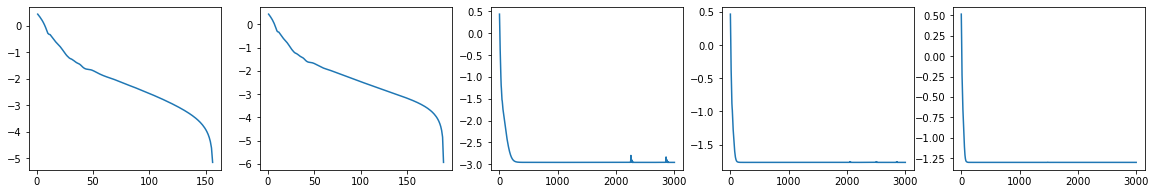

In [177]:
# TAKES A LONG TIME TO RUN ( 5 min? )
# 200 s
_gs_b, gs_b_iter = M.iter_GS_beta(max_iters=700, store_iters=True)
_gs_o, gs_o_iter = M.iter_GS_ordered(max_iters=700, store_iters=True)
ordX, ordY= zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in gs_o_iter))
bgsX, bgsY= zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in gs_b_iter))

print("finished GS")

gammas = [0, 0.01, 0.1, 0.5, 1]
fig, axes = plt.subplots(1, len(gammas), figsize=(4*len(gammas), 3))
Opts, Iters, Losses = [], [], []
OptXY = [()]*len(gammas)

for i,gamma in enumerate(gammas):
    print('*'*20, '  gamma = ', gamma, ' ', '*'*20)
    opt, iters, losses = M._torch_opt_inc(gamma=gamma,
        iters=3000, 
        ret_losses=True, ret_iterates=True, extraTemp=0)
    print('\nmin: ', min(losses))
    Opts.append(opt)
    Iters.append(iters)
    Losses.append(losses)
    axes[i].plot([np.log(l - min(losses) - min(losses)/10)/np.log(10) for l in losses])
     
    OptXY[i] = list(zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in Iters[i])))


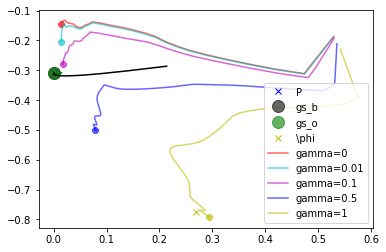

In [191]:
fig, ax = plt.subplots() 

ax.plot( M.Inc(P).real, M.IDef(P), 'bx', label="P" )
# ax.plot( M.Inc(_opt.npify()).real, M.IDef(_opt.npify()), 'ro', label="opt", alpha=0.6, markersize=12)
ax.plot( M.Inc(_gs_b.npify()).real, M.IDef(_gs_b.npify()), 'ko',label="gs_b", alpha=0.6, markersize=12)
ax.plot( M.Inc(_gs_o.npify()).real, M.IDef(_gs_o.npify()), 'go', label="gs_o", alpha=0.6, markersize=12 )
ax.plot(ordX[1:],ordY[1:], '-g')
ax.plot(bgsX[10:],bgsY[10:], '-k')
fp = M.factor_product()
ax.plot( M.Inc(fp).real, M.IDef(fp), 'yx', label="\phi" )

for i,(g,spec) in enumerate(zip(gammas, ['-r', '-c', '-m',  '-b', '-y','-g'])):
    ax.plot(*[xy[10:] for xy in OptXY[i]], spec, label='gamma='+str(gammas[i]), alpha=0.6)
    ax.plot(M.Inc(Opts[i].npify()).real, M.IDef(Opts[i].npify()), spec[-1]+'8', alpha=0.6)

ax.legend()
plt.show()

In [167]:
pca_view(
    
)

StopIteration: 

In [335]:
# TAKES A LONG TIME TO RUN ( 5 min? )
# 200 s
_gs_b, gs_b_iter = M.iter_GS_beta(max_iters=2700, store_iters=True)
_gs_o, gs_o_iter = M.iter_GS_ordered(max_iters=2700, store_iters=True)
ordX, ordY= zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in gs_o_iter))
bgsX, bgsY= zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in gs_b_iter))

print("finished GS")

# gammas = [0,1E-8, 0.01, 0.1, 0.5, 0.75, 1]
# fig, axes = plt.subplots(1, len(gammas), figsize=(4*len(gammas), 3))
# Opts, Iters, Losses = [], [], []
# OptXY = [()]*len(gammas)

# for i,gamma in enumerate(gammas):
#     print('*'*20, '  gamma = ', gamma, ' ', '*'*20)
#     opt, iters, losses = M._torch_opt_inc(gamma=gamma,
#         iters=300, optimizer='lbfgs', lr=1E-2,
#         ret_losses=True, ret_iterates=True, extraTemp=0)
#     print('\nmin: ', min(losses))
#     Opts.append(opt)
#     Iters.append(iters)
#     Losses.append(losses)
#     axes[i].plot([np.log(l - min(losses) - min(losses)/10)/np.log(10) for l in losses])
     
#     OptXY[i] = list(zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in Iters[i])))


finished GS


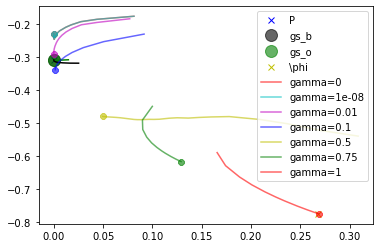

In [212]:
fig, ax = plt.subplots() 

ax.plot( M.Inc(P).real, M.IDef(P), 'bx', label="P" )
# ax.plot( M.Inc(_opt.npify()).real, M.IDef(_opt.npify()), 'ro', label="opt", alpha=0.6, markersize=12)
ax.plot( M.Inc(_gs_b.npify()).real, M.IDef(_gs_b.npify()), 'ko',label="gs_b", alpha=0.6, markersize=12)
ax.plot( M.Inc(_gs_o.npify()).real, M.IDef(_gs_o.npify()), 'go', label="gs_o", alpha=0.6, markersize=12 )
ax.plot(ordX[1:],ordY[1:], '-g')
ax.plot(bgsX[20:],bgsY[20:], '-k')
fp = M.factor_product()
ax.plot( M.Inc(fp).real, M.IDef(fp), 'yx', label="\phi" )

from itertools import cycle

for i,(g,spec) in enumerate(zip(gammas, cycle(['-r', '-c', '-m',  '-b', '-y','-g']))):
    ax.plot(*[xy[4:] for xy in OptXY[i]], spec, label='gamma='+str(gammas[i]), alpha=0.6)
    ax.plot(M.Inc(Opts[i].npify()).real, M.IDef(Opts[i].npify()), spec[-1]+'8', alpha=0.6)

ax.legend()
plt.show()

In [213]:
print( M.IDef( Opts[gammas.index(1E-8)] ).item(),  M.IDef( _gs_b ))
print( M.Inc( Opts[gammas.index(1E-8)].npify() ),  M.Inc( _gs_b ))


-0.22954925975794183 -0.30910916881012973
(3.35594512746216e-05+0j) (4.031617727458971e-16+0j)


Note that `_gs_b` has lower IDef AND lower Inc than the `1E-8` point.

In [267]:
# WW = Var.product(M.varlist)
# len(WW)
_gs_b.data.min(), Opts[gammas.index(1E-8)].data.min(), (Opts[gammas.index(1E-8)].npify().data == 0).sum()

(3.308987730512404e-07, tensor(1.6954e-06, dtype=torch.float64), 0)

## Trying a different representation with LBFGS

[]
********************   gamma =  0   ********************
[498/500]  loss:  3.317e-09;  lr: 1.000e+00; 	 graient magnitude: 9.460e-08 	 
min:  3.317025987215061e-09
********************   gamma =  1e-08   ********************
[498/500]  loss:  -1.034e-08;  lr: 1.000e+00; 	 graient magnitude: 9.407e-08 	 
min:  -1.0338351508210053e-08
********************   gamma =  1e-06   ********************
[498/500]  loss:  -1.319e-06;  lr: 1.000e+00; 	 graient magnitude: 1.179e-07 	 
min:  -1.3189006722313934e-06
********************   gamma =  0.0001   ********************
[498/500]  loss:  -1.346e-04;  lr: 1.000e+00; 	 graient magnitude: 1.538e-07 	 
min:  -0.00013456445594783872
********************   gamma =  0.01   ********************
[498/500]  loss:  -1.355e-02;  lr: 1.000e+00; 	 graient magnitude: 2.546e-07 	 
min:  -0.013552182354032993
********************   gamma =  0.1   ********************
[498/500]  loss:  -1.414e-01;  lr: 1.000e+00; 	 graient magnitude: 1.729e-07 	 
min:  -0.141

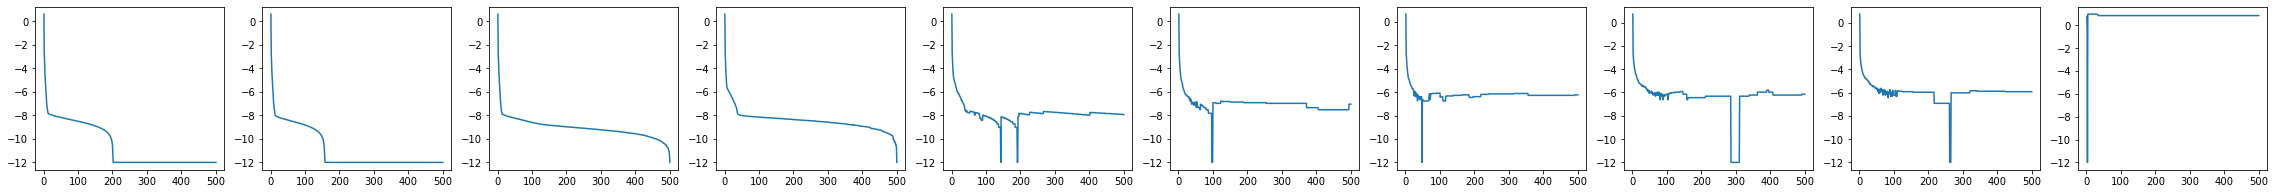

In [355]:
gammas = [0, 1E-8, 1E-6, 1E-4, 0.01, 0.1, 0.5, 0.75, 0.875, 1]
# gammas = [-1E-8, 0,1E-8, 1E-6, 1E-4, 0.01, 0.1, 0.5, 0.75, 0.875, 1]
fig, axes = plt.subplots(1, len(gammas), figsize=(4*len(gammas), 3))
if len(Opts) != len(gammas) or True:
    Opts, Iters, Losses = [()]*len(gammas), [()]*len(gammas), [()]*len(gammas)
    OptXY = [()]*len(gammas)

skip = [ ] # gammas[:-1]
print(skip)

gsinit = lambda shape,dtype: torch.tensor(_gs_b.data, dtype=dtype)

for i,gamma in enumerate(gammas):
    if gamma in skip:
        continue
    print('*'*20, '  gamma = ', gamma, ' ', '*'*20)
    opt, iters, losses = M._torch_opt_inc(gamma=gamma,ret_losses=True, ret_iterates=True, extraTemp=0,
        iters=500, optimizer='lbfgs', lr=1, representation='gibbs', constraint_penalty=0,
            tolerance_grad=1e-8, tolerance_change=1e-12,
            # init=gsinit
        # iters=2000, optimizer='asgd', lr=1E-4, representation='soft simplex', constraint_penalty=0,
        # iters=500, optimizer='lbfgs', lr=1E-3, representation='simplex', constraint_penalty=0,
        #     tolerance_grad=1e-7, tolerance_change=1e-12,
        # iters=2000, optimizer='adam', lr=1E-3, representation='simplex', constraint_penalty=0,
    )
    print('\nmin: ', min(losses))
    Opts[i] = opt
    # Iters.append(iters[::len(iters)//100])
    # Losses.append(losses[::len(losses)//100])
    losses = np.array(losses)
    Iters[i] = iters
    Losses[i] = losses
    axes[i].plot(np.log(losses - losses.min() + 1E-12)/np.log(10))     
    OptXY[i] = list(zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in Iters[i])))

In [354]:
Opts = Opts[10:]
len(Opts)

1

The following suggests that it's not optimal for IDef: the gradient of the torch score seems very large

In [331]:
_gs_b_torch = _gs_b.torchify()
_gs_b_torch.require_grad()
l = M.torch_score(_gs_b_torch, 0.01)
l.backward()
print( torch.norm(_gs_b_torch.data.grad) )

tensor(1.1203, dtype=torch.float64)


... but it turns out that's actually smaller than the gradient for other values of gamma......

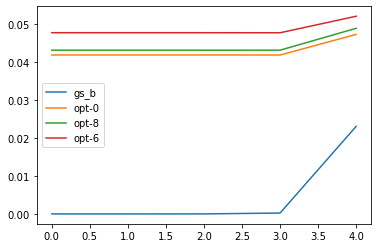

In [337]:

namedist = { 'gs_b' : _gs_b, #'opt--8': Opts[gammas.index(-1e-8)],
    'opt-0': Opts[gammas.index(0)], 
    'opt-8': Opts[gammas.index(1e-8)], 'opt-6': Opts[gammas.index(1e-6)]}
Gs = [0, 1E-12, 1E-8, 1E-6, 1E-4, 1E-2, 1E-1, 1][:5]

for name,dist in namedist.items():
    vals = [0]*len(Gs)
    for i,g in enumerate(Gs):
        _dist_torch = dist.torchify()
        _dist_torch.require_grad()
        M.torch_score(_dist_torch, g).backward()
        vals[i] = torch.norm(_dist_torch.data.grad)

    plt.plot(vals, label=name)
plt.legend()
plt.show()


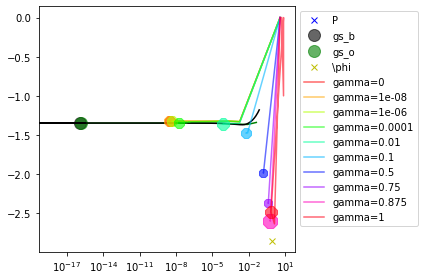

In [356]:
fig, ax = plt.subplots() 

ax.plot( M.Inc(P).real, M.IDef(P), 'bx', label="P" )
ax.plot( M.Inc(_gs_b.npify()).real, M.IDef(_gs_b.npify()), 'ko',label="gs_b", alpha=0.6, markersize=12)
ax.plot( M.Inc(_gs_o.npify()).real, M.IDef(_gs_o.npify()), 'go', label="gs_o", alpha=0.6, markersize=12 )
ax.plot(ordX[1:],ordY[1:], '-g')
ax.plot(bgsX[20:],bgsY[20:], '-k')
fp = M.factor_product()
ax.plot( M.Inc(fp).real, M.IDef(fp), 'yx', label="\phi" )

from itertools import cycle
from matplotlib.cm import get_cmap

for i,(g,clr) in enumerate(zip(gammas[:], get_cmap('hsv')(np.linspace(0,1,len(gammas[:]))) )):
    ax.semilogx(*[xy[1:] for xy in OptXY[i]], color=clr, ls='-', label='gamma='+str(gammas[i]), alpha=0.6)
    ax.semilogx(M.Inc(Opts[i].npify()).real, M.IDef(Opts[i].npify()),marker='8', alpha=0.6, color=clr, markersize=random.randint(8,15))

ax.legend(loc="upper left", bbox_to_anchor=(1,1))
#ax.legend()
plt.tight_layout()
plt.show()

Now for the same thing but where you start at the GS point...

[]
********************   gamma =  0   ********************
[296/300]  loss:  4.173e-17;  lr: 1.000e-02; 	 graient magnitude: 2.266e-14 	 
min:  4.173425629711769e-17
********************   gamma =  1e-08   ********************
[296/300]  loss:  -1.347e-08;  lr: 1.000e-02; 	 graient magnitude: 5.415e-10 	 
min:  -1.3468302029195911e-08
********************   gamma =  1e-06   ********************
[296/300]  loss:  -1.347e-06;  lr: 1.000e-02; 	 graient magnitude: 5.415e-08 	 
min:  -1.34683125452284e-06
********************   gamma =  0.0001   ********************
[296/300]  loss:  -1.347e-04;  lr: 1.000e-02; 	 graient magnitude: 5.345e-06 	 
min:  -0.00013468314136844128
********************   gamma =  0.01   ********************
[296/300]  loss:  -1.348e-02;  lr: 1.000e-02; 	 graient magnitude: 4.294e-04 	 
min:  -0.01348219532519579
********************   gamma =  0.1   ********************
[296/300]  loss:  -1.361e-01;  lr: 1.000e-02; 	 graient magnitude: 4.342e-03 	 
min:  -0.136087

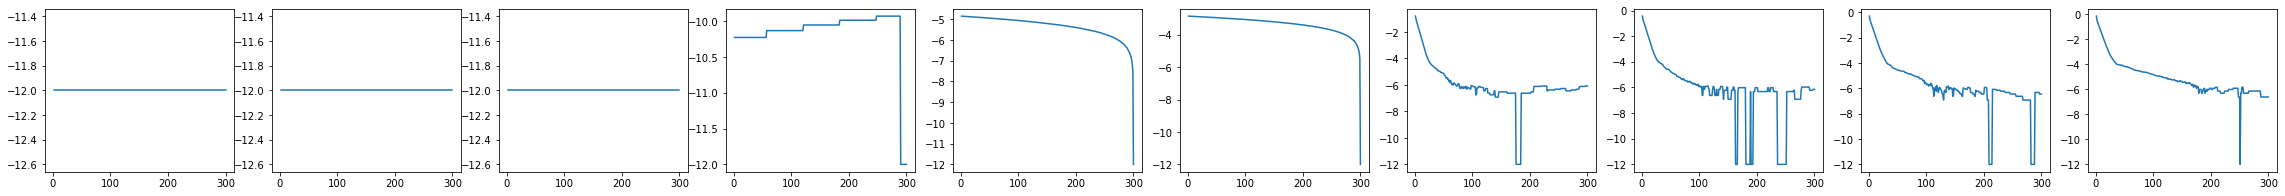

In [357]:
gammas = [0, 1E-8, 1E-6, 1E-4, 0.01, 0.1, 0.5, 0.75, 0.875, 1]
# gammas = [-1E-8, 0,1E-8, 1E-6, 1E-4, 0.01, 0.1, 0.5, 0.75, 0.875, 1]
fig, axes = plt.subplots(1, len(gammas), figsize=(4*len(gammas), 3))
if len(Opts) != len(gammas) or True:
    Opts, Iters, Losses = [()]*len(gammas), [()]*len(gammas), [()]*len(gammas)
    OptXY = [()]*len(gammas)

skip = [ ] # gammas[:-1]
print(skip)

gsinit = lambda shape,dtype: torch.tensor(np.log(_gs_b.data), dtype=dtype)

for i,gamma in enumerate(gammas):
    if gamma in skip:
        continue
    print('*'*20, '  gamma = ', gamma, ' ', '*'*20)
    opt, iters, losses = M._torch_opt_inc(gamma=gamma,ret_losses=True, ret_iterates=True, extraTemp=0,
        iters=300, optimizer='lbfgs', lr=1E-2, representation='gibbs', constraint_penalty=0,
            tolerance_grad=1e-8, tolerance_change=1e-12,
            init=gsinit
        # iters=2000, optimizer='asgd', lr=1E-4, representation='soft simplex', constraint_penalty=0,
        # iters=500, optimizer='lbfgs', lr=1E-3, representation='simplex', constraint_penalty=0,
        #     tolerance_grad=1e-7, tolerance_change=1e-12,
        # iters=2000, optimizer='adam', lr=1E-3, representation='simplex', constraint_penalty=0,
    )
    print('\nmin: ', min(losses))
    Opts[i] = opt
    # Iters.append(iters[::len(iters)//100])
    # Losses.append(losses[::len(losses)//100])
    losses = np.array(losses)
    Iters[i] = iters
    Losses[i] = losses
    axes[i].plot(np.log(losses - losses.min() + 1E-12)/np.log(10))     
    OptXY[i] = list(zip(*( (M.Inc(RJD(t,M.varlist)).real, M.IDef(RJD(t,M.varlist))) for t in Iters[i])))

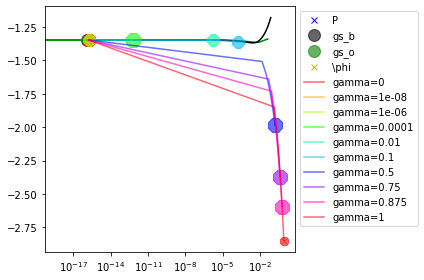

In [358]:
fig, ax = plt.subplots() 

ax.plot( M.Inc(P).real, M.IDef(P), 'bx', label="P" )
ax.plot( M.Inc(_gs_b.npify()).real, M.IDef(_gs_b.npify()), 'ko',label="gs_b", alpha=0.6, markersize=12)
ax.plot( M.Inc(_gs_o.npify()).real, M.IDef(_gs_o.npify()), 'go', label="gs_o", alpha=0.6, markersize=12 )
ax.plot(ordX[1:],ordY[1:], '-g')
ax.plot(bgsX[20:],bgsY[20:], '-k')
fp = M.factor_product()
ax.plot( M.Inc(fp).real, M.IDef(fp), 'yx', label="\phi" )

from itertools import cycle
from matplotlib.cm import get_cmap

for i,(g,clr) in enumerate(zip(gammas[:], get_cmap('hsv')(np.linspace(0,1,len(gammas[:]))) )):
    ax.semilogx(*[xy[1:] for xy in OptXY[i]], color=clr, ls='-', label='gamma='+str(gammas[i]), alpha=0.6)
    ax.semilogx(M.Inc(Opts[i].npify()).real, M.IDef(Opts[i].npify()),marker='8', alpha=0.6, color=clr, markersize=random.randint(8,15))

ax.legend(loc="upper left", bbox_to_anchor=(1,1))
#ax.legend()
plt.tight_layout()
plt.show()

In [376]:
print( Opts[gammas.index(1E-8)] // _gs_b, Opts[gammas.index(0)] // _gs_b)
print( Opts[gammas.index(0)].npify() // Opts[gammas.index(1E-8)].npify())
print( {g : M.IDef(o.npify()) - M.IDef(_gs_b) for g,o in zip(gammas,Opts)})

-2.465880754155531e-15 -2.465880754155531e-15
0.0
{0: -8.881784197001252e-16, 1e-08: -8.881784197001252e-16, 1e-06: -8.881784197001252e-16, 0.0001: -8.857030131537158e-07, 0.01: -0.0015529739267359233, 0.1: -0.01572029715867007, 0.5: -0.6392595445287323, 0.75: -1.0238833651639236, 0.875: -1.2482513271239188, 1: -1.5037020323497945}
